
Dataset: Fashion-MNIST



Trained on: GrayScale Fashion-MNIST

Tested on: GrayScale Fashion-MNIST & Randomly-Colored-Fashion-MNIST

Model: CNN with 2 Conv Layers, 2 Max Pooling Layers, and 2 Fully Connected Layers


In [1]:
import os


os.chdir('../../experiments')

# print("Current working directory:", os.getcwd())

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import random


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Load Fashion-MNIST dataset

In [3]:

directory = "../data"
files = os.listdir(directory)
files

['FashionMNIST', 'MNIST']

In [4]:
transform = transforms.Compose([
    # Convert grayscale to 3-channel RGB
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
                         )  # Normalize for 3 channels

])

In [5]:
train_batch_size = 64
test_batch_size = 128

In [6]:
train_dataset = datasets.FashionMNIST(
    directory, train=True, download=True, transform=transform)

test_dataset = datasets.FashionMNIST(
    directory, train=False, transform=transform)

train_loader = DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False)

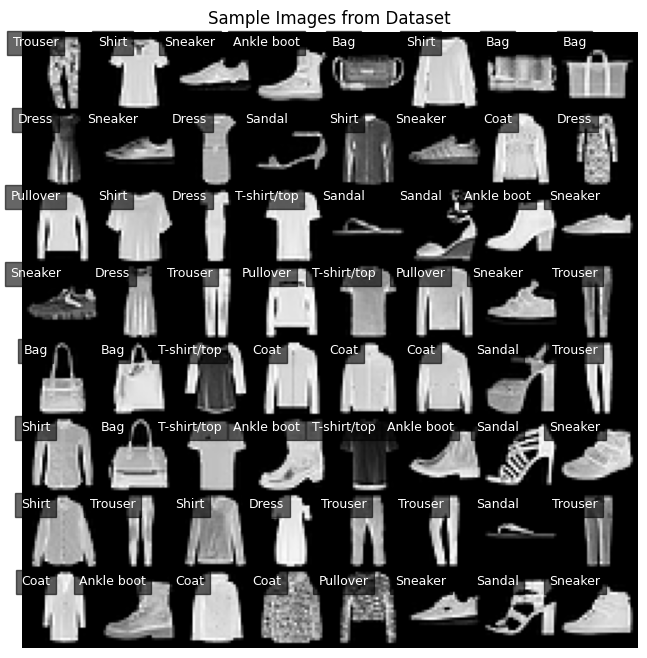

In [7]:
fashion_mnist_classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


def show_images_from_loader(loader, classes=fashion_mnist_classes, n_images=64):

    # Get a batch of images and labels
    images, labels = next(iter(loader))

    # Select n_images from the batch
    images, labels = images[:n_images], labels[:n_images]

    # Create a grid of images
    grid = utils.make_grid(images, nrow=int(
        n_images**0.5), padding=2, normalize=True)

    plt.figure(figsize=(8, 8))
    # Convert from (C, H, W) to (H, W, C) for plotting
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Sample Images from Dataset")

    for i, label in enumerate(labels):
        row, col = divmod(i, int(n_images**0.5))
        plt.text(col * (grid.size(2) / n_images**0.5) + 5,
                 row * (grid.size(1) / n_images**0.5) + 5,
                 classes[label.item()],
                 color='white', fontsize=9, ha='center', bbox=dict(facecolor='black', alpha=0.6))
    plt.show()


show_images_from_loader(train_loader)

Train on the grayscale Fashion-MNIST dataset

In [8]:
# from train import Net, train, test, ood_detection
from train import train, test
from cnn import _2LayerCNN

In [9]:
model = _2LayerCNN().to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [10]:
for epoch in range(1, 5):
    train(model, device, train_loader, optimizer, epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325322
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.496038
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.440149
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.336907
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.568857
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.498129
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.288983
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.257035
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.204474
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.533389
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.354014
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.258595
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.121801
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.302407
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.315622
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.316096
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.230271
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.342499
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.159521
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.242272
Train Epoch:

In [11]:
test(model, device, test_loader)


Test set: Average loss: 0.0020, Accuracy: 9144/10000 (91.44%)



color the test set as our ood set

In [12]:


# Define a custom transformation to add artificial color
class RandomColorize:
    def __call__(self, img):
        # Split the single channel into 3 identical channels
        img = F.to_tensor(img)  # Convert to tensor
        img = img.repeat(3, 1, 1)  # Duplicate grayscale channel to 3 channels

        # Apply random scaling to each channel
        r, g, b = random.uniform(0.6, 1.4), random.uniform(
            0.6, 1.4), random.uniform(0.6, 1.4)
        img[0] *= r  # Scale the red channel
        img[1] *= g  # Scale the green channel
        img[2] *= b  # Scale the blue channel

        # Clip values to the range [0, 1]
        img = torch.clamp(img, 0, 1)
        return img

In [13]:

color_transform = transforms.Compose([
    RandomColorize(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
                         )  # Normalize 3 channels
])

# Load the test dataset with the color transformation
colored_test_dataset = datasets.FashionMNIST(
    root=directory, train=False, transform=color_transform, download=True)
colored_test_loader = DataLoader(
    colored_test_dataset, batch_size=64, shuffle=False)

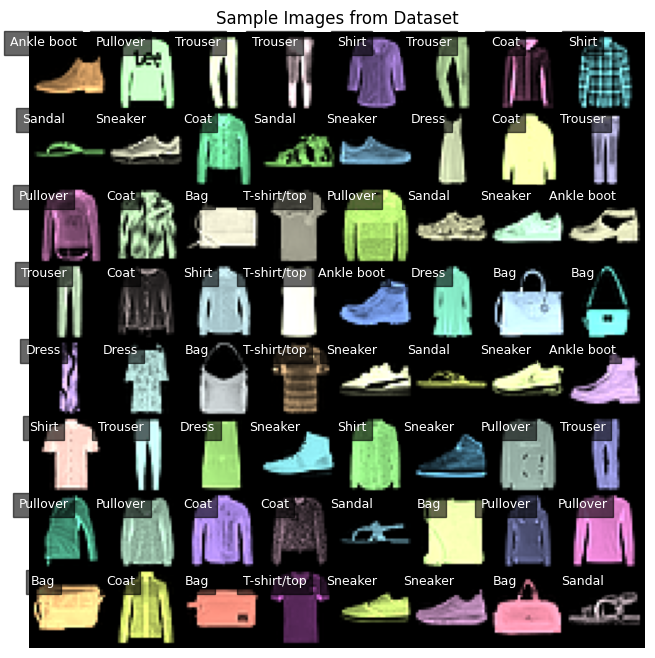

In [14]:
show_images_from_loader(colored_test_loader)

In [15]:
test(model, device, colored_test_loader)


Test set: Average loss: 0.0043, Accuracy: 9073/10000 (90.73%)



perform ood detection

In [16]:
from ood_detection import OODDetection

In [17]:
ood_detector = OODDetection(model, device)

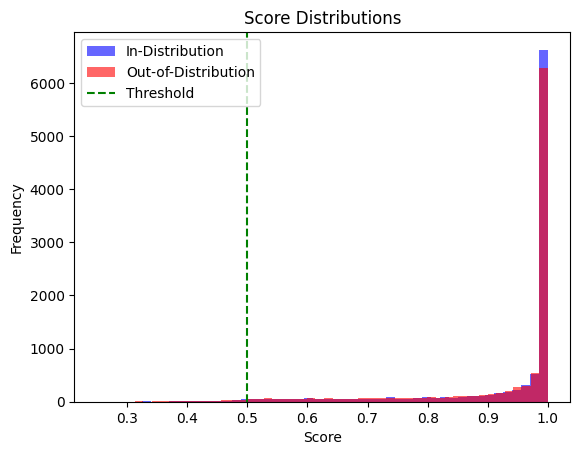

Threshold OOD Detection: Softmax Threshold = 0.50 with scoring function: <function OODDetection.max_confidence at 0x00000177DA1F7600>
In-Distribution Detection Rate: 0.98
Out-of-Distribution Detection Rate: 0.02
OOD samples classified as ID: 98.29%
OOD samples classified as OD: 1.71%


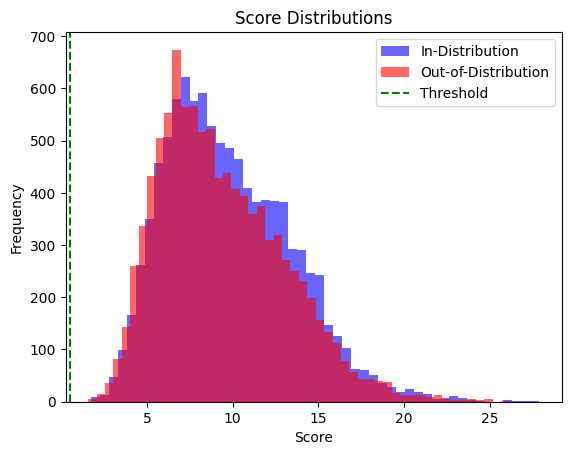

Threshold OOD Detection: Softmax Threshold = 0.50 with scoring function: <function OODDetection.energy_score at 0x00000177DA1F7420>
In-Distribution Detection Rate: 1.00
Out-of-Distribution Detection Rate: 0.00
OOD samples classified as ID: 100.00%
OOD samples classified as OD: 0.00%


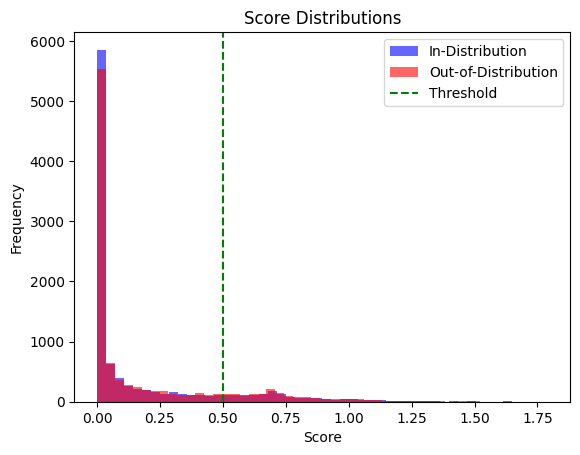

Threshold OOD Detection: Softmax Threshold = 0.50 with scoring function: <function OODDetection.entropy_score at 0x00000177DA1F76A0>
In-Distribution Detection Rate: 0.15
Out-of-Distribution Detection Rate: 0.85
OOD samples classified as ID: 16.53%
OOD samples classified as OD: 83.47%


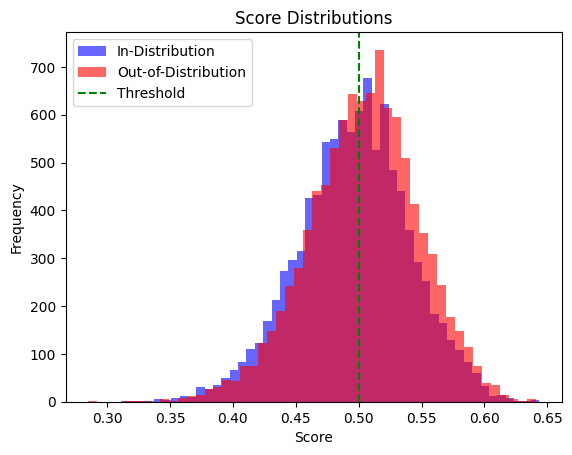

Logistic Regression OOD Detection: Decision Threshold = 0.50
In-Distribution Detection Rate: 0.48
Out-of-Distribution Detection Rate: 0.52
OOD samples classified as ID: 44.80%
OOD samples classified as OD: 55.20%


In [18]:
results = ood_detector.run_all_methods(test_loader, colored_test_loader)

In [19]:
results

{'threshold': {'in_detection_rate': 0.1455,
  'ood_detection_rate': 0.8545,
  'ood_as_id_percent': 16.53,
  'ood_as_od_percent': 83.47},
 'logistic_regression': {'in_detection_rate': 0.4827,
  'ood_detection_rate': 0.5173,
  'ood_as_id_percent': 44.8,
  'ood_as_od_percent': 55.2,
  'accuracy': 0.53465,
  'logistic_regression_model': LogisticRegression()}}